In [77]:
import polars as pl
import random
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a synthetic dataset using a function
def generate_synthetic_data(num_observations):
    data = {
        "user_id": [random.randint(1, 1000) for _ in range(num_observations)],
        "timestamp": [datetime(2023, 5, 1) + timedelta(days=random.randint(0, 30)) for _ in range(num_observations)],
        "action": ["view", "click", "purchase", "view", "click"] * (num_observations // 5)
    }
    return pl.DataFrame(data)

num_observations = 1000000
df = generate_synthetic_data(num_observations)

In [2]:
#pip install polars random datetime

In [78]:
# Step 2: Optimize a query efficiently
filtered_df = df.filter(df["action"] == "purchase")

In [79]:
# Step 3: Find a trend based on a funnel point
funnel = filtered_df.groupby(["timestamp", "action"]).agg({"user_id": pl.sum})
trend_df = funnel.groupby("timestamp").agg({"user_id": pl.sum})

print(trend_df)

shape: (31, 2)
┌─────────────────────┬─────────────────────┐
│ timestamp           ┆ user_id             │
│ ---                 ┆ ---                 │
│ datetime[μs]        ┆ list[list[i64]]     │
╞═════════════════════╪═════════════════════╡
│ 2023-05-04 00:00:00 ┆ [[924, 36, … 879]]  │
│ 2023-05-22 00:00:00 ┆ [[475, 569, … 756]] │
│ 2023-05-02 00:00:00 ┆ [[93, 89, … 938]]   │
│ 2023-05-27 00:00:00 ┆ [[134, 919, … 117]] │
│ …                   ┆ …                   │
│ 2023-05-05 00:00:00 ┆ [[717, 54, … 826]]  │
│ 2023-05-21 00:00:00 ┆ [[598, 721, … 98]]  │
│ 2023-05-07 00:00:00 ┆ [[266, 438, … 426]] │
│ 2023-05-12 00:00:00 ┆ [[196, 895, … 573]] │
└─────────────────────┴─────────────────────┘


In [80]:
# For Pandas instead of Polars
# Step 3: Find a trend based on a funnel point
#funnel = filtered_df.group(["timestamp", "action"]).agg(pl.sum(df["user_id"]).alias("users"))
#funnel = funnel.group("timestamp").agg(pl.sum(funnel["users"]).alias("total_users"))
#trend_df = funnel.select(["timestamp", "total_users"])

#print(trend_df)

In [81]:
# Step 3 (View focused): Filter and group by "view" actions
filtered_df = df.filter(df["action"] == "view")
grouped_df = filtered_df.groupby("timestamp").agg(pl.count("action").alias("view_count"))

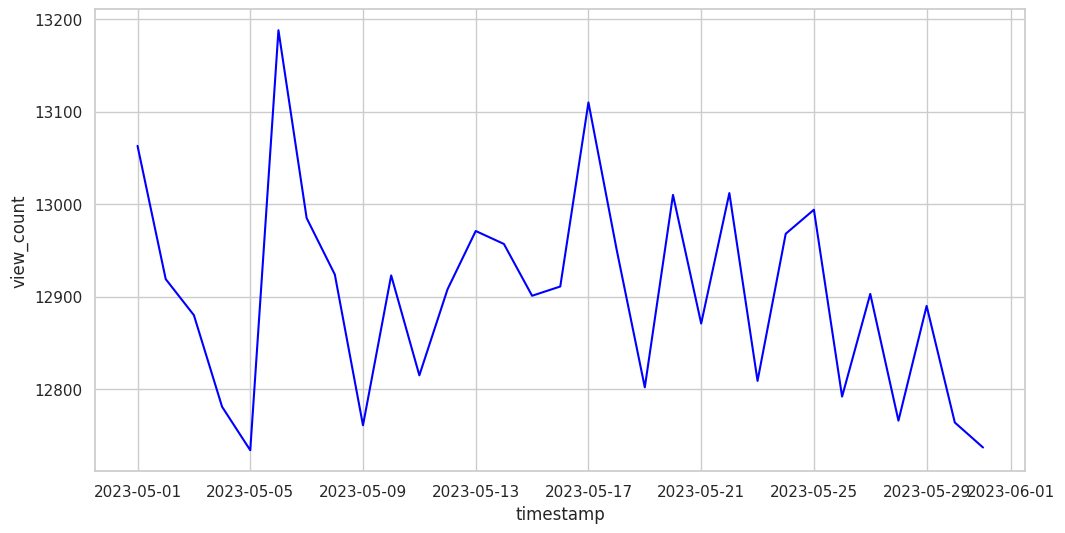

In [82]:
# Step 4: Convert the timestamp to datetime64
grouped_df = grouped_df.with_columns(
    pl.col("timestamp").cast(pl.Date)
)

# Step 5: Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=grouped_df.to_pandas(), x="timestamp", y="view_count", color='blue')

# Add seasonal trend line
#x_numeric = np.arange(len(grouped_df))  # Convert timestamp to numeric values
#seasonal_trend = sns.regplot(
#    x=x_numeric,  # Use numeric values
#    y=grouped_df["view_count"].to_pandas(),
#    order=3,
#    scatter=False,
#    ax=ax,
#    color='orange'
#)

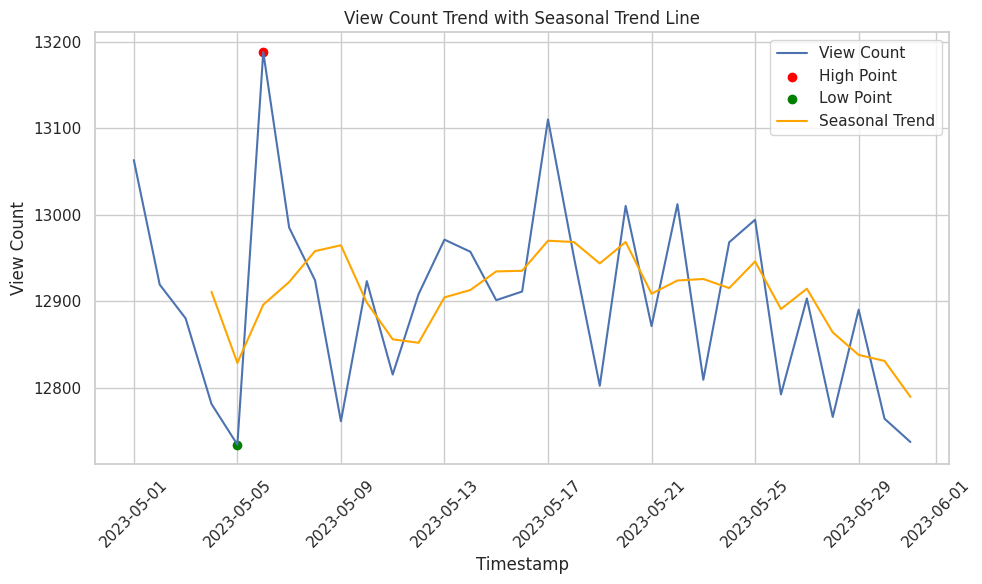

In [83]:
# Filter for "view" actions
filtered_df = df.filter(df["action"] == "view")

# Group by timestamp and count views
grouped_df = filtered_df.groupby("timestamp").agg(pl.count("action").alias("view_count"))

# Sort by timestamp
grouped_df_sorted = grouped_df.sort("timestamp")

# Plot the view counts
plt.figure(figsize=(10, 6))
plt.plot(grouped_df_sorted["timestamp"], grouped_df_sorted["view_count"], label="View Count")

# Highlight high and low points
high_index = grouped_df_sorted["view_count"].arg_max()
low_index = grouped_df_sorted["view_count"].arg_min()
high_point = grouped_df_sorted[high_index].to_pandas()
low_point = grouped_df_sorted[low_index].to_pandas()

plt.scatter(high_point["timestamp"], high_point["view_count"], color='red', label="High Point")
plt.scatter(low_point["timestamp"], low_point["view_count"], color='green', label="Low Point")

# Add a seasonal trend line
seasonal_trend = grouped_df_sorted["view_count"].rolling_mean(window_size=4)
plt.plot(grouped_df_sorted["timestamp"], seasonal_trend, label="Seasonal Trend", color='orange')

# Customize the plot
plt.xlabel("Timestamp")
plt.ylabel("View Count")
plt.title("View Count Trend with Seasonal Trend Line")
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()